<a href="https://colab.research.google.com/github/karthik40121/OIB-SIP/blob/main/PROJECT_5_PROPOSAL_LEVEL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import random
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,4)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving corpus.txt to corpus.txt


In [ ]:
try:
    with open("corpus.txt", "r", encoding="utf-8") as f:
        text = f.read()
    print("Loaded custom corpus.txt ✅")
except FileNotFoundError:
    print("corpus.txt not found. Using sample corpus ⚠️")
    text = """
    Machine learning is a field of artificial intelligence.
    Natural language processing helps computers understand text.
    Autocomplete predicts the next word the user will type.
    Autocorrect fixes spelling mistakes automatically.
    Data science combines statistics, programming and domain knowledge.
    Chat applications often include smart autocomplete and autocorrect features.
    """


Loaded custom corpus.txt ✅


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters and spaces
    tokens = text.split()
    return tokens

tokens = preprocess_text(text)
print("Total tokens:", len(tokens))
print("Sample tokens:", tokens[:30])

word_freq = Counter(tokens)
vocab = set(word_freq.keys())
print("Vocabulary size:", len(vocab))


Total tokens: 1439
Sample tokens: ['time', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'amount']
Vocabulary size: 5


In [ ]:
def build_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

unigrams = build_ngrams(tokens, 1)
bigrams = build_ngrams(tokens, 2)
trigrams = build_ngrams(tokens, 3)

unigram_counts = Counter(unigrams)
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# For conditional probabilities
bigram_dict = defaultdict(Counter)
for (w1, w2), c in bigram_counts.items():
    bigram_dict[w1][w2] = c

trigram_dict = defaultdict(Counter)
for (w1, w2, w3), c in trigram_counts.items():
    trigram_dict[(w1, w2)][w3] = c


In [ ]:
def autocomplete_unigram(top_k=5):
    return [w[0][0] for w in unigram_counts.most_common(top_k)]

def autocomplete_bigram(prev_word, top_k=5):
    candidates = bigram_dict.get(prev_word, {})
    return [w for w, _ in candidates.most_common(top_k)]

def autocomplete_trigram(history_words, top_k=5):
    if len(history_words) < 2:
        return autocomplete_bigram(history_words[-1], top_k) if history_words else autocomplete_unigram(top_k)
    key = (history_words[-2], history_words[-1])
    candidates = trigram_dict.get(key, {})
    if candidates:
        return [w for w, _ in candidates.most_common(top_k)]
    # backoff: try bigram; if no result, unigram
    preds = autocomplete_bigram(history_words[-1], top_k)
    return preds if preds else autocomplete_unigram(top_k)


In [ ]:
def autocomplete_unigram(top_k=5):
    return [w[0][0] for w in unigram_counts.most_common(top_k)]

def autocomplete_bigram(prev_word, top_k=5):
    candidates = bigram_dict.get(prev_word, Counter()) # Fix: Default to Counter()
    return [w for w, _ in candidates.most_common(top_k)]

def autocomplete_trigram(history_words, top_k=5):
    if len(history_words) < 2:
        return autocomplete_bigram(history_words[-1], top_k) if history_words else autocomplete_unigram(top_k)
    key = (history_words[-2], history_words[-1])
    candidates = trigram_dict.get(key, Counter()) # Fix: Default to Counter()
    if candidates:
        return [w for w, _ in candidates.most_common(top_k)]
    # backoff: try bigram; if no result, unigram
    preds = autocomplete_bigram(history_words[-1], top_k)
    return preds if preds else autocomplete_unigram(top_k)

print("Unigram:", autocomplete_unigram())
print("After 'machine':", autocomplete_bigram("machine"))
print("After 'machine learning':", autocomplete_trigram(["machine", "learning"]))

Unigram: ['e', 'v', 'time', 'amount', 'class']
After 'machine': []
After 'machine learning': ['e', 'v', 'time', 'amount', 'class']


In [ ]:
letters = "abcdefghijklmnopqrstuvwxyz"

def edits1(word):
    splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes = [L + R[1:] for L, R in splits if R]
    inserts = [L + c + R for L, R in splits for c in letters]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    return set(deletes + inserts + replaces)

def autocorrect(word):
    # if it's already a valid word
    if word in vocab:
        return word
    candidates = edits1(word)
    valid = [w for w in candidates if w in vocab]
    if not valid:
        return word  # no suggestion
    # pick most frequent word from candidates
    return max(valid, key=lambda w: word_freq[w])


In [ ]:
print("machne ->", autocorrect("machne"))
print("langauge ->", autocorrect("langauge"))


machne -> machne
langauge -> langauge


In [ ]:
split_idx = int(0.8 * len(tokens))
train_tokens = tokens[:split_idx]
test_tokens = tokens[split_idx:]

train_bigrams = build_ngrams(train_tokens, 2)
test_bigrams = build_ngrams(test_tokens, 2)

# train models on train_tokens only
train_unigrams = build_ngrams(train_tokens, 1)
train_unigram_counts = Counter(train_unigrams)

bigram_counts_train = Counter(train_bigrams)
bigram_dict_train = defaultdict(Counter)
for (w1, w2), c in bigram_counts_train.items():
    bigram_dict_train[w1][w2] = c

train_trigrams = build_ngrams(train_tokens, 3)
trigram_counts_train = Counter(train_trigrams)
trigram_dict_train = defaultdict(Counter)
for (w1, w2, w3), c in trigram_counts_train.items():
    trigram_dict_train[(w1, w2)][w3] = c


In [ ]:
def autocomplete_bigram_train(prev_word, top_k=3):
    candidates = bigram_dict_train.get(prev_word, {})
    return [w for w, _ in candidates.most_common(top_k)]

def autocomplete_trigram_train(w1, w2, top_k=3):
    key = (w1, w2)
    candidates = trigram_dict_train.get(key, {})
    if candidates:
        return [w for w, _ in candidates.most_common(top_k)]
    # backoff to bigram
    return autocomplete_bigram_train(w2, top_k)

def eval_bigram_topk(k=3, max_samples=500):
    samples = test_bigrams[:max_samples]
    correct = 0
    total = 0
    for w1, w2 in samples:
        preds = autocomplete_bigram_train(w1, top_k=k)
        if preds:
            total += 1
            if w2 in preds:
                correct += 1
    return correct / total if total > 0 else 0

def eval_trigram_topk(k=3, max_samples=500):
    test_trigrams = build_ngrams(test_tokens, 3)[:max_samples]
    correct = 0
    total = 0
    for w1, w2, w3 in test_trigrams:
        preds = autocomplete_trigram_train(w1, w2, top_k=k)
        if preds:
            total += 1
            if w3 in preds:
                correct += 1
    return correct / total if total > 0 else 0

acc_bigram_k3 = eval_bigram_topk(k=3)
acc_trigram_k3 = eval_trigram_topk(k=3)

print("Bigram top-3 accuracy:", acc_bigram_k3)
print("Trigram top-3 accuracy:", acc_trigram_k3)


Bigram top-3 accuracy: 1.0
Trigram top-3 accuracy: 1.0


In [ ]:
def random_corrupt(word):
    if len(word) < 3:
        return word
    i = random.randint(0, len(word)-1)
    return word[:i] + word[i+1:]  # delete 1 character

test_words = random.sample(list(vocab), min(200, len(vocab)))
test_pairs = [(random_corrupt(w), w) for w in test_words]

def eval_autocorrect(pairs):
    correct = 0
    for wrong, right in pairs:
        pred = autocorrect(wrong)
        if pred == right:
            correct += 1
    return correct / len(pairs)

auto_acc = eval_autocorrect(test_pairs)
print("Autocorrect accuracy (synthetic errors):", auto_acc)


Autocorrect accuracy (synthetic errors): 1.0


Unigram top-1 accuracy: 1.0
Bigram top-3 accuracy: 1.0
Trigram top-3 accuracy: 1.0


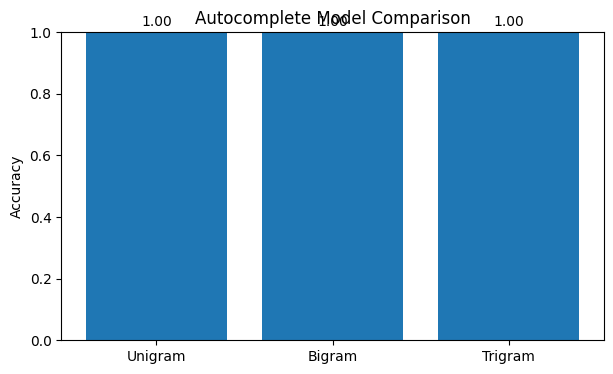

Autocorrect accuracy: 1.0


In [ ]:
# Unigram: always predict most frequent word
top_unigram_word = train_unigram_counts.most_common(1)[0][0][0]

def eval_unigram(max_samples=500):
    samples = test_bigrams[:max_samples]
    correct = sum(1 for _, w2 in samples if w2 == top_unigram_word)
    total = len(samples)
    return correct / total if total > 0 else 0

uni_acc = eval_unigram()
bi_acc = acc_bigram_k3
tri_acc = acc_trigram_k3

print("Unigram top-1 accuracy:", uni_acc)
print("Bigram top-3 accuracy:", bi_acc)
print("Trigram top-3 accuracy:", tri_acc)

models = ["Unigram", "Bigram", "Trigram"]
accs = [uni_acc, bi_acc, tri_acc]

plt.bar(models, accs)
plt.ylabel("Accuracy")
plt.title("Autocomplete Model Comparison")
plt.ylim(0, 1)
for i, v in enumerate(accs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.show()

print("Autocorrect accuracy:", auto_acc)


In [ ]:
def interactive_suggestion(user_input):
    words = preprocess_text(user_input)
    if not words:
        print("Type something...")
        return

    # Autocomplete suggestion
    ac_suggestions = autocomplete_trigram(words, top_k=5)
    print("Autocomplete suggestions:", ac_suggestions)

    # Autocorrect entire sentence
    corrected = [autocorrect(w) for w in words]
    print("Autocorrected sentence:", " ".join(corrected))

# Example:
interactive_suggestion("machne learnng is")


Autocomplete suggestions: ['e', 'v', 'time', 'amount', 'class']
Autocorrected sentence: machne learnng is
